### Imports

In [35]:
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

### Desafio:

Este é o Trabalho 1 de avaliação da disciplina EEL891 (Introdução ao Aprendizado de Máquina) para a turma do período 2020-1.

Neste trabalho você construirá um classificador para apoio à decisão de aprovação de crédito.

A ideia é identificar, dentre os clientes que solicitam um produto de crédito (como um cartão de crédito ou um empréstimo pessoal, por exemplo) e que cumprem os pré-requisitos essenciais para a aprovação do crédito, aqueles que apresentem alto risco de não conseguirem honrar o pagamento, tornando-se inadimplentes.

Para isso, você receberá um arquivo com dados históricos de 20.000 solicitações de produtos de créditos que foram aprovadas pela instituição, acompanhadas do respectivo desfecho, ou seja, acompanhadas da indicação de quais desses solicitantes conseguiram honrar os pagamentos e quais ficaram inadimplentes.

Com base nesses dados históricos, você deverá construir um classificador que, a partir dos dados de uma nova solicitação de crédito, tente predizer se este solicitante será um bom ou mau pagador.

O objetivo da competição é disputar com seus colegas quem consegue obter a acurácia mais alta em um conjunto de 5.000 solicitações de crédito aprovadas (diferentes das 20.000 anteriores) cujos desfechos (quitação da dívida ou inadimplência) são mantidos ocultos no site do Kaggle, que medirá automaticamente a taxa de acerto das previsões enviadas pelos competidores, sem revelar o "gabarito".

### Leitura de dados

In [11]:
test = pd.read_csv('data/desafio 1/conjunto_de_teste.csv')
train = pd.read_csv('data/desafio 1/conjunto_de_treinamento.csv')

print(test.shape)
print(train.shape)
print('\n')
print(f'test columns {test.columns}')
print('\n')
print(f'train columns {train.columns}')
print('\n')
print(list(set(train.columns.tolist()) - set(test.columns.tolist())))

(5000, 41)
(20000, 42)


test columns Index(['id_solicitante', 'produto_solicitado', 'dia_vencimento',
       'forma_envio_solicitacao', 'tipo_endereco', 'sexo', 'idade',
       'estado_civil', 'qtde_dependentes', 'grau_instrucao', 'nacionalidade',
       'estado_onde_nasceu', 'estado_onde_reside',
       'possui_telefone_residencial', 'codigo_area_telefone_residencial',
       'tipo_residencia', 'meses_na_residencia', 'possui_telefone_celular',
       'possui_email', 'renda_mensal_regular', 'renda_extra',
       'possui_cartao_visa', 'possui_cartao_mastercard',
       'possui_cartao_diners', 'possui_cartao_amex', 'possui_outros_cartoes',
       'qtde_contas_bancarias', 'qtde_contas_bancarias_especiais',
       'valor_patrimonio_pessoal', 'possui_carro',
       'vinculo_formal_com_empresa', 'estado_onde_trabalha',
       'possui_telefone_trabalho', 'codigo_area_telefone_trabalho',
       'meses_no_trabalho', 'profissao', 'ocupacao', 'profissao_companheiro',
       'grau_instrucao_compa

In [110]:
test.isna().sum() 

id_solicitante                         0
produto_solicitado                     0
dia_vencimento                         0
forma_envio_solicitacao                0
tipo_endereco                          0
sexo                                   0
idade                                  0
estado_civil                           0
qtde_dependentes                       0
grau_instrucao                         0
nacionalidade                          0
estado_onde_nasceu                     0
estado_onde_reside                     0
possui_telefone_residencial            0
codigo_area_telefone_residencial       0
tipo_residencia                      125
meses_na_residencia                  362
possui_telefone_celular                0
possui_email                           0
renda_mensal_regular                   0
renda_extra                            0
possui_cartao_visa                     0
possui_cartao_mastercard               0
possui_cartao_diners                   0
possui_cartao_am

### Data Cleaning

In [12]:

# Drop useless columns
def drop_useless_cols(df):
    return df.drop(columns=['profissao_companheiro','grau_instrucao_companheiro', 
                            'local_onde_trabalha', 'local_onde_reside',
                            'meses_no_trabalho', 'possui_cartao_visa',
                            'possui_cartao_mastercard', 'possui_cartao_diners',
                            'possui_cartao_amex', 'forma_envio_solicitacao', 
                            'qtde_contas_bancarias_especiais',
                            'codigo_area_telefone_trabalho',
                            'codigo_area_telefone_residencial',
                            'estado_onde_trabalha',
                            'possui_telefone_trabalho',
                            'grau_instrucao', 'possui_telefone_celular'
])

train_dropped = drop_useless_cols(train)
test_dropped = drop_useless_cols(test)

# Transform text columns
def encode_string_col(df, col):
    df[col] = df[col].astype('category').cat.codes
    
# sexo 
train_dropped['sexo'].fillna('N')
test_dropped['sexo'].fillna('N')
encode_string_col(train_dropped, 'sexo')
encode_string_col(test_dropped, 'sexo')

# estado_onde_nasceu ... etc (general string columns)
string_cols = ['estado_onde_nasceu', 'estado_onde_reside', 'possui_telefone_residencial', 
               'vinculo_formal_com_empresa']

for col in string_cols:
    encode_string_col(train_dropped, col)
    encode_string_col(test_dropped, col)

# renda total

train_dropped['renda_total'] = train_dropped['renda_extra'] + train_dropped['renda_mensal_regular']
train_dropped.drop(columns=['renda_extra', 'renda_mensal_regular'], inplace=True)

test_dropped['renda_total'] = test_dropped['renda_extra'] + test_dropped['renda_mensal_regular']
test_dropped.drop(columns=['renda_extra', 'renda_mensal_regular'], inplace=True)

# fill na
train_dropped.fillna(0, inplace=True)
test_dropped.fillna(0, inplace=True)


print(train_dropped.columns)


Index(['id_solicitante', 'produto_solicitado', 'dia_vencimento',
       'tipo_endereco', 'sexo', 'idade', 'estado_civil', 'qtde_dependentes',
       'nacionalidade', 'estado_onde_nasceu', 'estado_onde_reside',
       'possui_telefone_residencial', 'tipo_residencia', 'meses_na_residencia',
       'possui_email', 'possui_outros_cartoes', 'qtde_contas_bancarias',
       'valor_patrimonio_pessoal', 'possui_carro',
       'vinculo_formal_com_empresa', 'profissao', 'ocupacao', 'inadimplente',
       'renda_total'],
      dtype='object')


### Cleaned test

In [13]:
test_dropped

,id_solicitante,produto_solicitado,dia_vencimento,tipo_endereco,sexo,idade,estado_civil,qtde_dependentes,nacionalidade,estado_onde_nasceu,...,meses_na_residencia,possui_email,possui_outros_cartoes,qtde_contas_bancarias,valor_patrimonio_pessoal,possui_carro,vinculo_formal_com_empresa,profissao,ocupacao,renda_total
0,20001,1,25,1,2,37,2,0,1,9,...,5.0,0,0,1,0.0,1,0,0.0,0.0,1800.00
1,20002,1,10,1,1,31,2,0,1,19,...,1.0,1,0,0,0.0,0,1,9.0,5.0,424.88
2,20003,1,10,1,1,18,2,0,1,23,...,12.0,1,0,0,0.0,0,1,9.0,2.0,400.00
3,20004,1,10,1,1,55,2,0,1,15,...,25.0,1,0,1,0.0,1,0,9.0,1.0,1400.00
4,20005,1,10,1,1,55,1,0,1,2,...,11.0,0,0,1,0.0,1,0,0.0,1.0,350.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,24996,1,10,1,1,49,2,1,1,10,...,8.0,0,0,1,0.0,1,0,9.0,1.0,700.00
4996,24997,1,5,1,2,18,2,0,1,18,...,2.0,1,0,0,0.0,0,0,0.0,0.0,640.00
4997,24998,1,10,1,1,29,1,0,1,10,...,2.0,1,0,0,0.0,0,0,9.0,5.0,500.00
4998,24999,1,25,1,1,31,2,2,1,14,...,10.0,1,0,0,0.0,0,1,0.0,0.0,350.00


### Cleaned train

In [127]:
train_dropped

,id_solicitante,produto_solicitado,dia_vencimento,tipo_endereco,sexo,idade,estado_civil,qtde_dependentes,grau_instrucao,nacionalidade,...,possui_email,possui_outros_cartoes,qtde_contas_bancarias,valor_patrimonio_pessoal,possui_carro,vinculo_formal_com_empresa,profissao,ocupacao,inadimplente,renda_total
0,1,1,10,1,2,85,2,0,0,1,...,0,0,1,0.0,1,0,9.0,1.0,0,480.0
1,2,1,25,1,1,38,1,0,0,1,...,1,0,0,0.0,0,0,2.0,5.0,0,380.0
2,3,1,20,1,1,37,2,0,0,1,...,1,0,0,0.0,0,0,0.0,0.0,1,600.0
3,4,1,20,1,2,37,1,1,0,1,...,1,0,0,0.0,0,1,9.0,2.0,1,460.0
4,5,7,1,1,1,51,1,3,0,1,...,1,0,0,0.0,1,1,9.0,5.0,1,1287.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19996,1,10,1,2,27,2,0,0,1,...,1,0,1,0.0,1,1,9.0,1.0,0,423.0
19996,19997,1,20,1,1,26,2,1,0,1,...,0,0,1,0.0,1,1,9.0,2.0,0,350.0
19997,19998,1,10,1,1,63,2,0,0,1,...,1,0,0,0.0,0,0,9.0,1.0,0,321.0
19998,19999,1,5,1,1,84,1,0,0,1,...,1,0,0,0.0,0,0,0.0,0.0,0,380.0


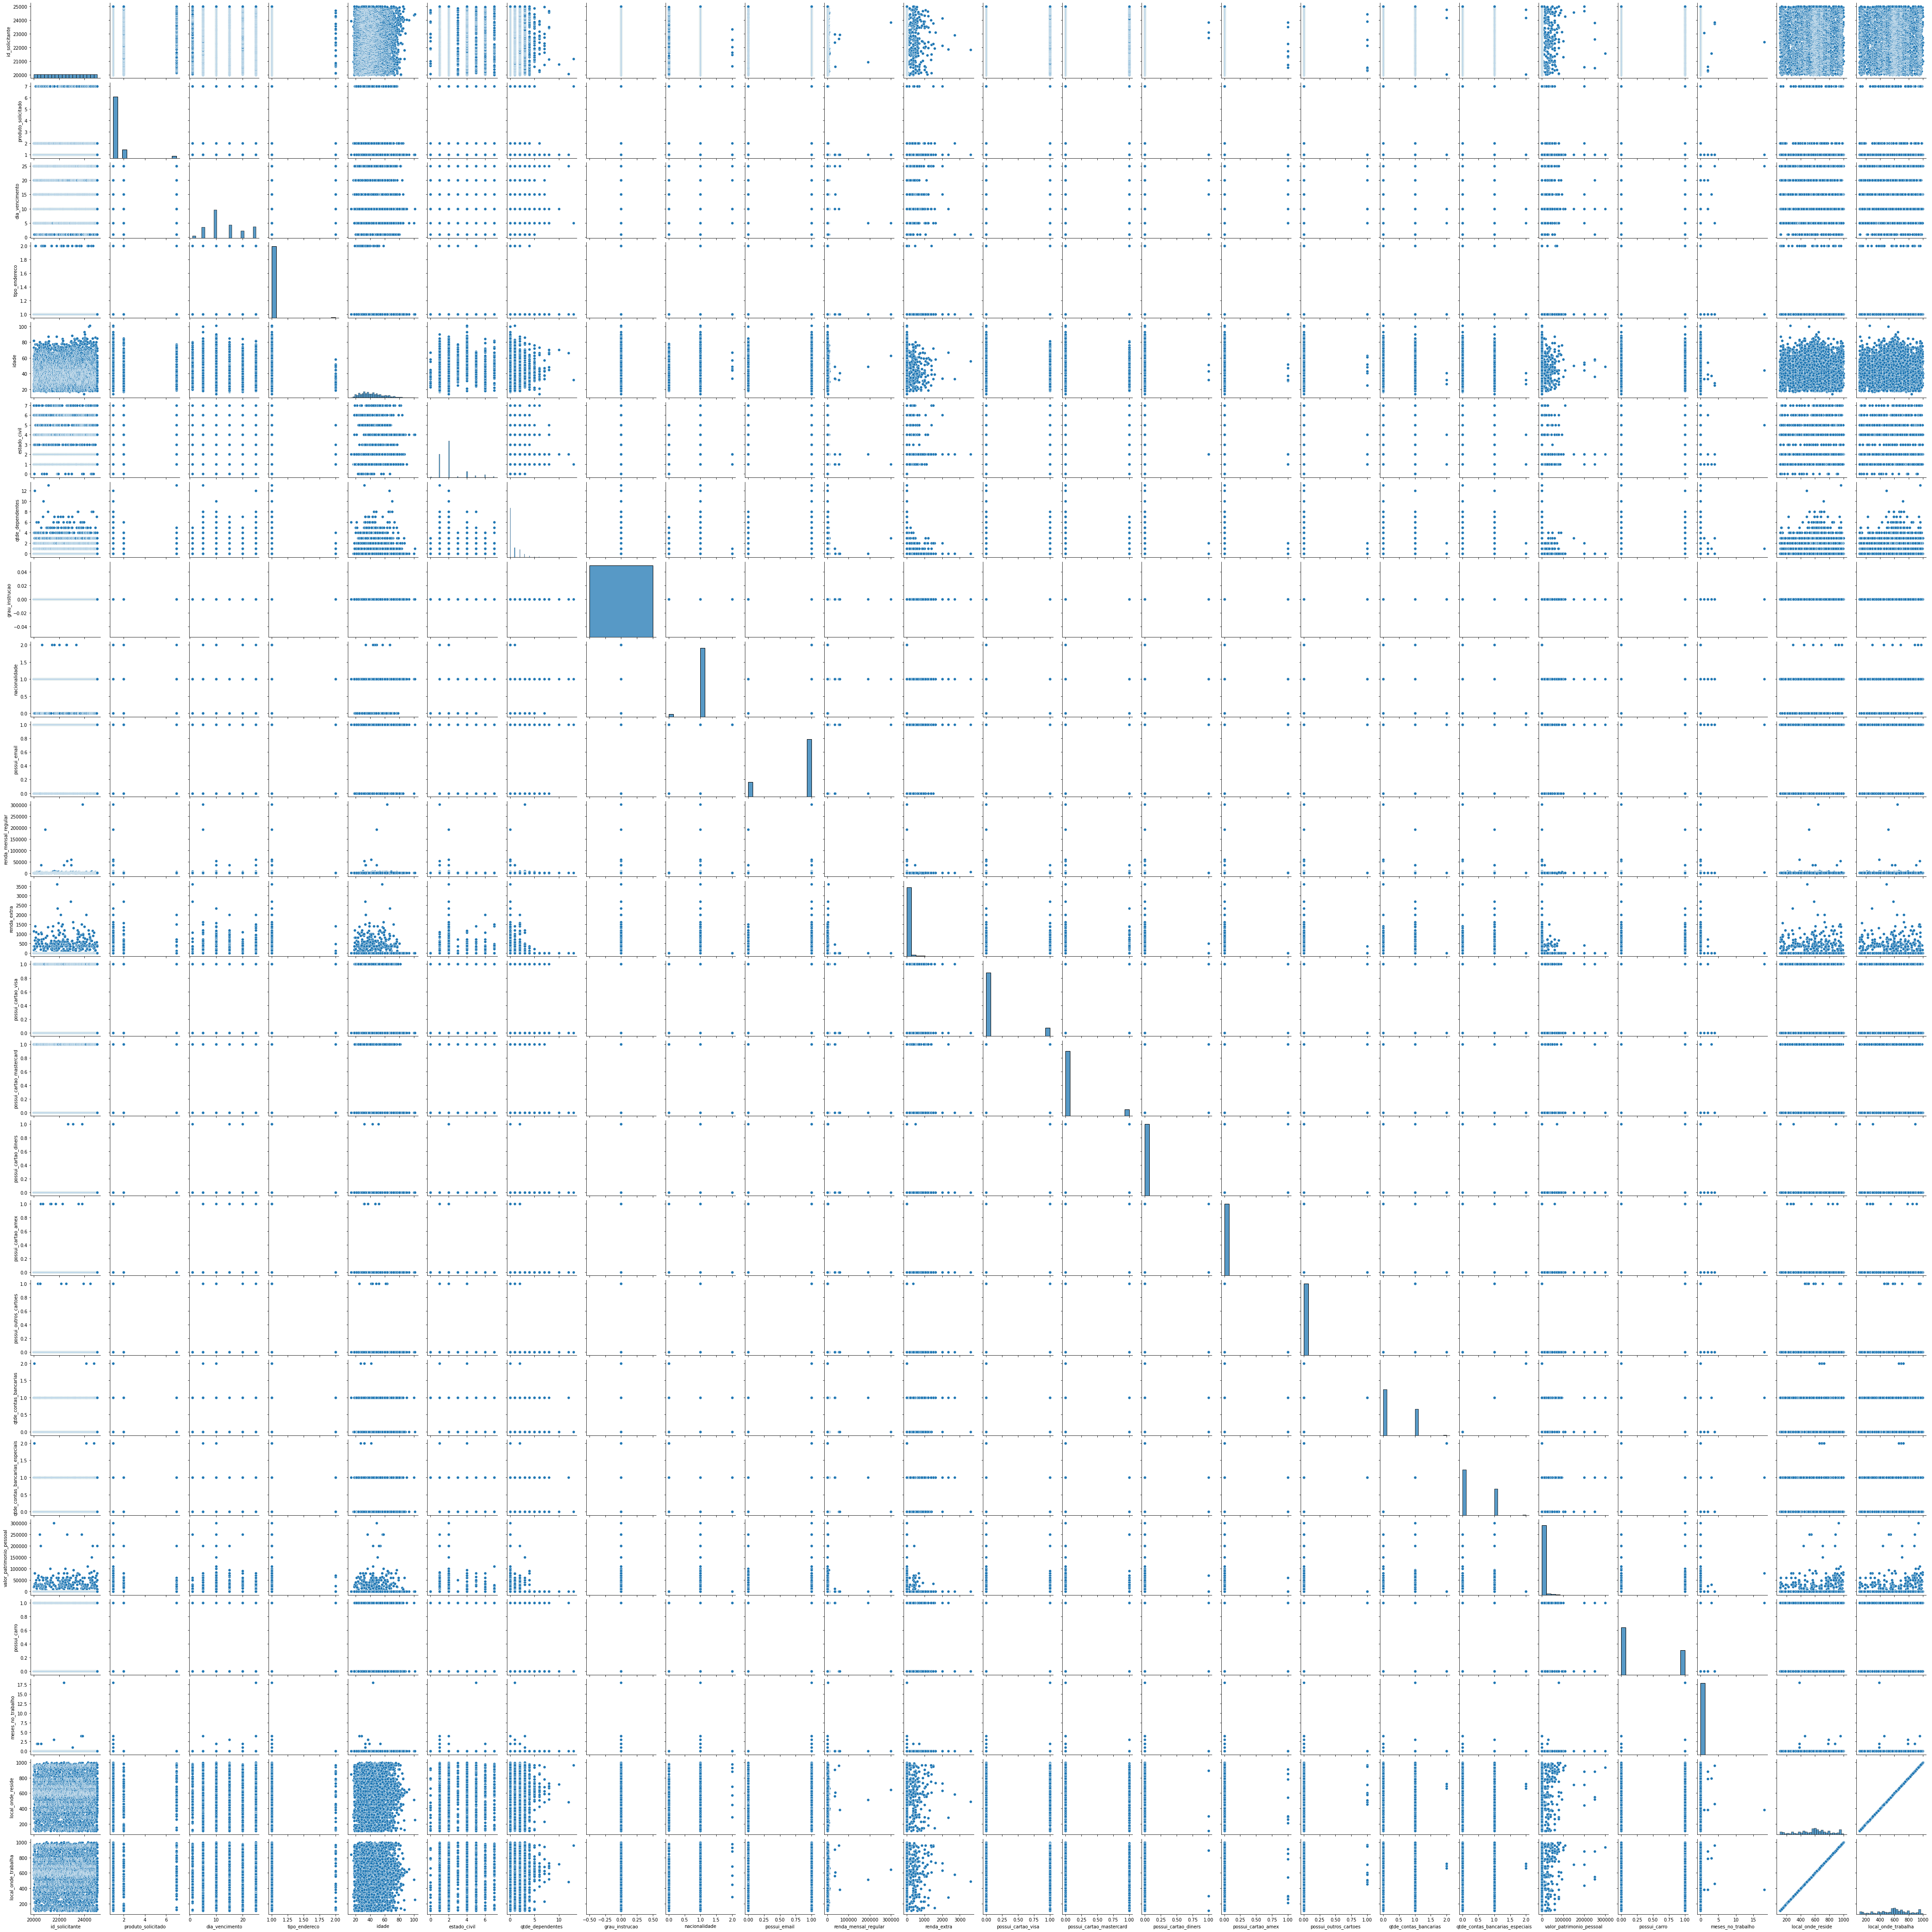

In [82]:
import seaborn as sns

sns.pairplot(test.select_dtypes(include='number'))


In [17]:
train = train_dropped
test = test_dropped
print(test.shape)
print(f'train shape {train.shape}')

y_train = train['inadimplente'].to_numpy()
print(set(y_train))
X_train = train.drop(columns=['inadimplente']).select_dtypes(include='number').to_numpy()
X_test = test.select_dtypes(include='number').to_numpy()
print(f'X_test len: {len(X_test)}')


print(X_train.shape)
print(y_train.shape)
knn = KNeighborsClassifier(n_neighbors=100)

# # Fit the classifier to the training data
knn.fit(X_train, y_train)

pred = knn.predict(X_test)
print(f'pred len {len(pred)}')
print(set(pred))
print(type(pred))

prediciton_df = pd.DataFrame({'id_solicitante' : test['id_solicitante'].to_numpy(),
                              'inadimplente' : pred})
# prediciton_df['inadimplente'] = pd.Series(pred)

prediciton_df.to_csv(f'data/desafio 1/prediction_knn_100.csv')


(5000, 23)
train shape (20000, 24)
{0, 1}
X_test len: 5000
(20000, 23)
(20000,)
pred len 5000
{0, 1}
<class 'numpy.ndarray'>


In [9]:
def knn(n):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    prediciton_df = pd.DataFrame({'id_solicitante' : test['id_solicitante'].to_numpy(),
                              'inadimplente' : pred})
    
    prediciton_df.to_csv(f'data/desafio 1/prediction_knn_{n}.csv')

In [131]:
pred = knn.predict(X_test)
print(f'pred len {len(pred)}')
print(set(pred))
print(type(pred))

prediciton_df = pd.DataFrame({'id_solicitante' : test['id_solicitante'].to_numpy(),
                              'inadimplente' : pred})
# prediciton_df['inadimplente'] = pd.Series(pred)

prediciton_df.to_csv(f'data/desafio 1/prediction_knn_{n}.csv')


pred len 5000
{0, 1}
<class 'numpy.ndarray'>


,id_solicitante,inadimplente
0,20001,0
1,20002,0
2,20003,0
3,20004,0
4,20005,0
...,...,...
4995,24996,0
4996,24997,0
4997,24998,0
4998,24999,0


### Logistic Regression

In [33]:
lr = LogisticRegression(penalty='l2', solver='liblinear')
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
prediciton_lr_df = pd.DataFrame({'id_solicitante' : test['id_solicitante'].to_numpy(),
                              'inadimplente' : pred_lr})

In [34]:
prediciton_lr_df.groupby('inadimplente').size()

inadimplente
0    2046
1    2954
dtype: int64

In [39]:
prediciton_lr_df.to_csv(f'data/desafio 1/predictions/prediction_lr_1.csv', index=False)

### Decision Tree

In [37]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
dtc_pred = dtc.predict(X_test)
prediciton_dtc_df = pd.DataFrame({'id_solicitante' : test['id_solicitante'].to_numpy(),
                              'inadimplente' : dtc_pred})

In [38]:
prediciton_dtc_df.groupby('inadimplente').size()

inadimplente
0    2341
1    2659
dtype: int64

In [40]:
prediciton_dtc_df.to_csv(f'data/desafio 1/predictions/prediction_dtc_1.csv', index=False)